### Basic library imports

In [1]:
import os
import pandas as pd

### Read Dataset

In [2]:
DATASET_FOLDER = '../dataset/'
train = pd.read_csv(os.path.join(DATASET_FOLDER, 'train.csv'))
test = pd.read_csv(os.path.join(DATASET_FOLDER, 'test.csv'))
sample_test = pd.read_csv(os.path.join(DATASET_FOLDER, 'sample_test.csv'))
sample_test_out = pd.read_csv(os.path.join(DATASET_FOLDER, 'sample_test_out.csv'))

### Run Sanity check using src/sanity.py

In [3]:
!python sanity.py --test_filename ../dataset/sample_test.csv --output_filename ../dataset/sample_test_out.csv

Parsing successfull for file: ../dataset/sample_test_out.csv


In [4]:
!python sanity.py --test_filename ../dataset/sample_test.csv --output_filename ../dataset/sample_test_out_fail.csv

Error: Invalid unit [lbs] found in 6.75 lbs. Allowed units: {'ton', 'foot', 'pound', 'kilovolt', 'centimetre', 'millivolt', 'kilogram', 'fluid ounce', 'gram', 'microgram', 'millilitre', 'centilitre', 'ounce', 'millimetre', 'kilowatt', 'quart', 'decilitre', 'gallon', 'yard', 'microlitre', 'volt', 'litre', 'inch', 'cubic foot', 'milligram', 'watt', 'metre', 'cup', 'cubic inch', 'pint', 'imperial gallon'}


### Download images

In [5]:
from utils import download_images
download_images(sample_test['image_link'], '../images')

100%|██████████| 88/88 [00:31<00:00,  2.78it/s]


In [6]:
assert len(os.listdir('../images')) > 0, "The ../images directory is empty." #returns images amount in the image directory

In [7]:
rmdir -rf ../images #deletes the image directory this for at last when done with the model

Invalid switch - "images".


## EDA and Initial Analysis

In [8]:
#Check for missing values training and test datasets
print(train.isnull().sum())
print(test.isnull().sum())

image_link      0
group_id        0
entity_name     0
entity_value    0
dtype: int64
index          0
image_link     0
group_id       0
entity_name    0
dtype: int64


In [9]:
# Image URLs Verification
import re

def is_valid_url(url):
    regex = re.compile(
        r'^(?:http|ftp)s?://' # http:// or https://
        r'(?:(?:[A-Z0-9](?:[A-Z0-9-]{0,61}[A-Z0-9])?\.)+(?:[A-Z]{2,6}\.?|[A-Z0-9-]{2,}\.?)|' # domain...
        r'localhost|' # localhost...
        r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}|' # ...or ipv4
        r'\[?[A-F0-9]*:[A-F0-9:]+\]?)' # ...or ipv6
        r'(?::\d+)?' # optional port
        r'(?:/?|[/?]\S+)$', re.IGNORECASE)
    return re.match(regex, url) is not None

# Validate URLs in the dataset
train['valid_url'] = train['image_link'].apply(is_valid_url)
print(train['valid_url'].value_counts())

valid_url
True    263859
Name: count, dtype: int64


In [10]:
#Feature Extraction
from PIL import Image

def get_image_info(image_path):
    try:
        with Image.open(image_path) as img:
            return img.format, img.size, img.mode
    except Exception as e:
        return None, None, None

image_path = 'C:/Users/User/Amazon_ML_Challenge_2024/student_resource 3/images/41-NCxNuBxL.jpg'
format, size, mode = get_image_info(image_path)
print(f"Format: {format}, Size: {size}, Mode: {mode}")

Format: JPEG, Size: (1600, 1600), Mode: RGB


In [11]:
import numpy as np
def preprocess_image(image_path, target_size=(224, 224)):
    try:
        with Image.open(image_path) as img:
            img = img.resize(target_size)
            img = img.convert('RGB')
            return np.array(img)
    except Exception as e:
        return None

preprocessed_image = preprocess_image('C:/Users/User/Amazon_ML_Challenge_2024/student_resource 3/images/41-NCxNuBxL.jpg')

                                          image_link  group_id  entity_name  \
0  https://m.media-amazon.com/images/I/61I9XdN6OF...    748919  item_weight   
1  https://m.media-amazon.com/images/I/71gSRbyXmo...    916768  item_volume   
2  https://m.media-amazon.com/images/I/61BZ4zrjZX...    459516  item_weight   
3  https://m.media-amazon.com/images/I/612mrlqiI4...    459516  item_weight   
4  https://m.media-amazon.com/images/I/617Tl40LOX...    731432  item_weight   

     entity_value  
0      500.0 gram  
1         1.0 cup  
2      0.709 gram  
3      0.709 gram  
4  1400 milligram  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263859 entries, 0 to 263858
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   image_link    263859 non-null  object
 1   group_id      263859 non-null  int64 
 2   entity_name   263859 non-null  object
 3   entity_value  263859 non-null  object
dtypes: int64(1), object(3)
memory us

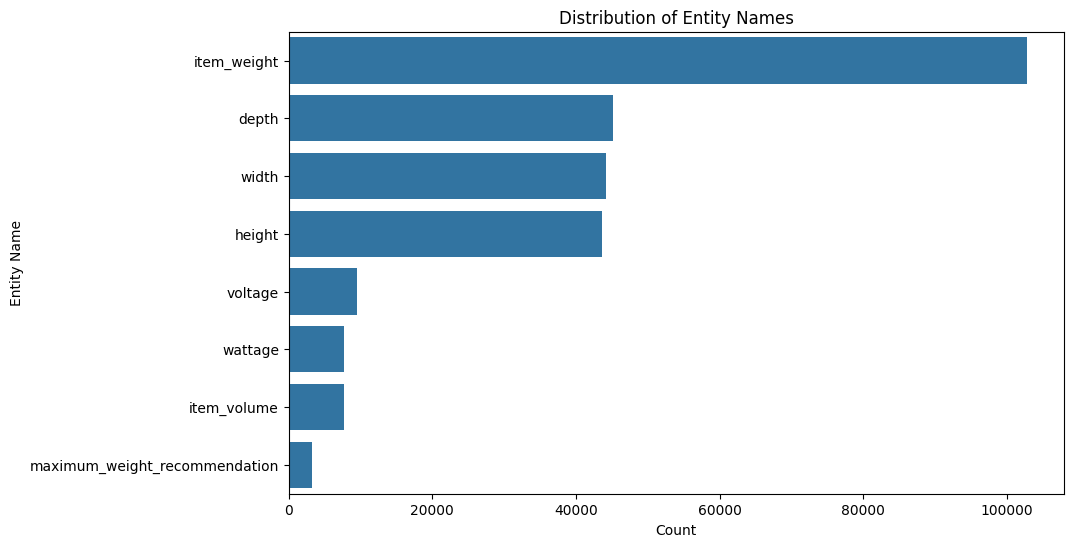

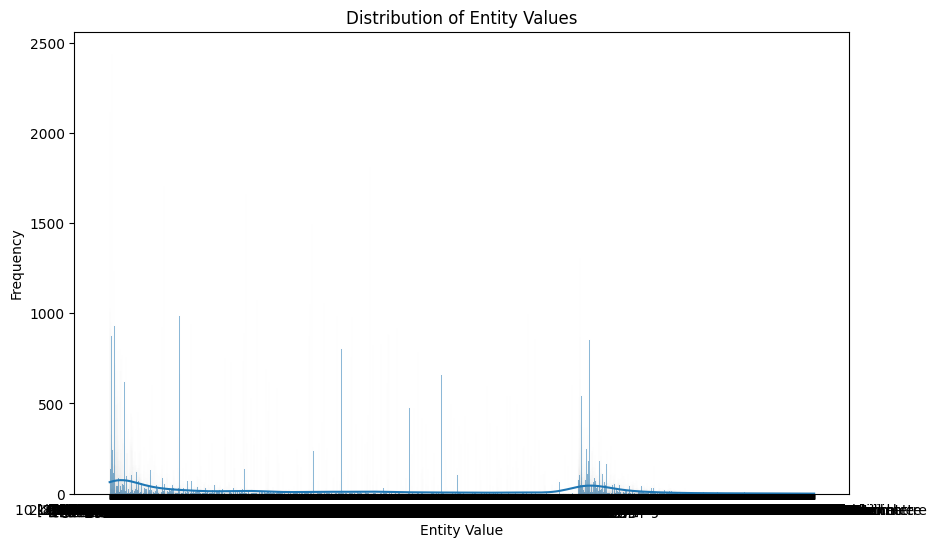

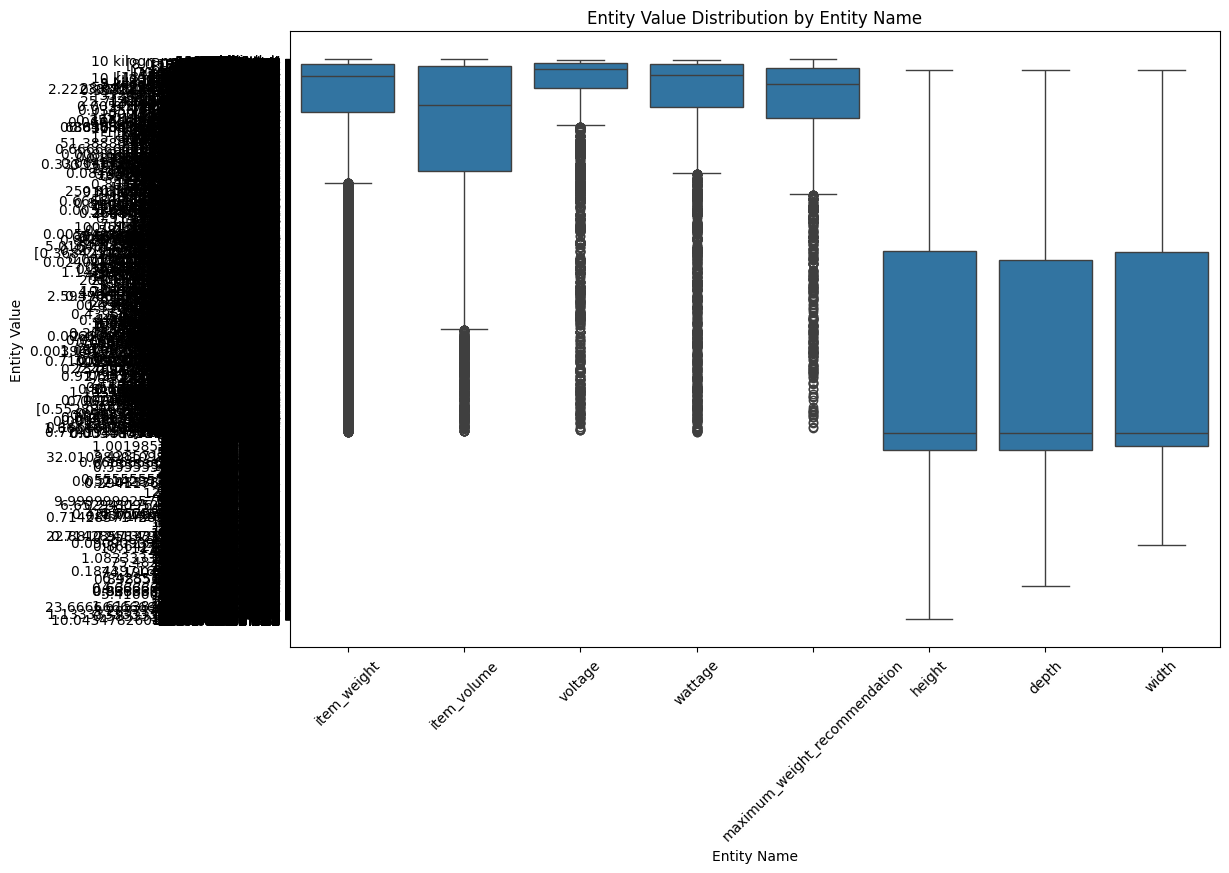

In [12]:
# EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('C:/Users/User/Amazon_ML_Challenge_2024/student_resource 3/dataset/train.csv')

# Display the first few rows of the dataset
print(df.head())

# Display basic information about the dataset
print(df.info())

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Drop rows with missing values or fill them, based on the context
df_cleaned = df.dropna()  # Example: Dropping rows with any missing values
# df_cleaned = df.fillna({'column_name': 'value'})  # Example: Filling missing values

# Verify that image URLs are properly formatted (basic check)
df_cleaned['image_link'] = df_cleaned['image_link'].astype(str)  # Ensure all URLs are strings
df_cleaned['url_length'] = df_cleaned['image_link'].apply(len)  # Length of URL to detect anomalies

# Display basic statistics of the URL length
print("URL Length Statistics:\n", df_cleaned['url_length'].describe())

# Visualize distribution of entity names
plt.figure(figsize=(10, 6))
sns.countplot(y='entity_name', data=df_cleaned, order=df_cleaned['entity_name'].value_counts().index)
plt.title('Distribution of Entity Names')
plt.xlabel('Count')
plt.ylabel('Entity Name')
plt.show()

# Visualize distribution of entity values
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['entity_value'], kde=True, bins=30)
plt.title('Distribution of Entity Values')
plt.xlabel('Entity Value')
plt.ylabel('Frequency')
plt.show()

# Analyze relationships between entity_name and entity_value
plt.figure(figsize=(12, 8))
sns.boxplot(x='entity_name', y='entity_value', data=df_cleaned)
plt.title('Entity Value Distribution by Entity Name')
plt.xlabel('Entity Name')
plt.ylabel('Entity Value')
plt.xticks(rotation=45)
plt.show()


In [13]:
from PIL import Image
#image resizing
def resize_image(image_path, target_size=(224, 224)):
    with Image.open(image_path) as img:
        img = img.resize(target_size, Image.ANTIALIAS)
    return img

In [14]:
import numpy as np
#Data Normalizationn
def normalize_image(image):
    image_array = np.array(image) / 255.0
    return image_array

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_image(image_array):
    image_array = image_array.reshape((1,) + image_array.shape)  # Reshape for datagen
    augmented_images = datagen.flow(image_array, batch_size=1)
    return next(augmented_images)[0]


ImportError: Traceback (most recent call last):
  File "c:\Users\User\miniconda3\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 70, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

## Data prepration

In [ ]:
import tensorflow as tf

def prepare_image_for_model(image_array):
    image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32)
    image_tensor = tf.expand_dims(image_tensor, axis=0)  # Add batch dimension
    return image_tensor


In [ ]:
def preprocess_image(image_path):
    # Load image
    img = resize_image(image_path)
    # Normalize image
    img_array = normalize_image(img)
    # Augment image (optional, used during training)
    img_array = augment_image(img_array)
    # Prepare for model input
    img_tensor = prepare_image_for_model(img_array)
    return img_tensor

In [ ]:
#For Training
import pandas as pd
download_image = 'C:/Users/User/Amazon_ML_Challenge_2024/student_resource 3/images'
train_df = pd.read_csv('dataset/train.csv')
for index, row in train_df.iterrows():
    image_path = download_image(row['image_link'])  #  actual image download code
    preprocessed_image = preprocess_image(image_path)
    # Save or use preprocessed_image for training

In [ ]:
#For testing
test_df = pd.read_csv('dataset/test.csv')
for index, row in test_df.iterrows():
    image_path = download_image(row['image_link'])  # actual image download code
    preprocessed_image = preprocess_image(image_path)
    # Use preprocessed_image for prediction

## Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import os
from PIL import Image
from io import BytesIO
import requests

# Define parameters
img_height, img_width = 224, 224
batch_size = 32
num_classes = 100  # Update based on your entity and unit classes

# Create ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    'train_directory',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'train_directory',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Build the model
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


## Model Training

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

## Model Eval

In [ ]:
def download_image(image_link):
    response = requests.get(image_link)
    img = Image.open(BytesIO(response.content))
    img = img.resize((img_height, img_width))
    img_array = np.array(img) / 255.0
    return img_array

def preprocess_image(image_link):
    img_array = download_image(image_link)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

In [ ]:
# Load test data
test_df = pd.read_csv('sample_test.csv')

# Create a reverse mapping from (entity, unit) to index
entity_unit_to_index = {}
index_to_entity_unit = {}

index = 0
for entity, units in entity_unit_map.items():
    for unit in units:
        entity_unit_to_index[(entity, unit)] = index
        index_to_entity_unit[index] = f"{entity} {unit}"
        index += 1

print("Entity-Unit to Index Mapping:", entity_unit_to_index)
print("Index to Entity-Unit Mapping:", index_to_entity_unit)

# Predict
predictions = []
for _, row in test_df.iterrows():
    img_array = preprocess_image(row['image_link'])
    preds = model.predict(img_array)
    pred_class = np.argmax(preds, axis=1)[0]
    # Assuming you have a mapping of class indices to entity_name and unit
    predicted_entity_unit = index_to_entity_unit[pred_class]
    predictions.append(predicted_entity_unit)

# Create submission DataFrame
submission_df = pd.DataFrame({
    'index': test_df['index'],
    'prediction': predictions
})

# Save to CSV
submission_df.to_csv('test_out.csv', index=False)

## Sanity Check

In [ ]:
python sanity_checker.py --output_file output.csv